In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from opacus import PrivacyEngine
from imblearn.over_sampling import SMOTE

# Load the KDD99 dataset (Assuming you have the dataset file 'kddcup.data_10_percent_corrected')
df = pd.read_csv('kddcup.data_10_percent_corrected', header=None)

# Define the column names based on KDD99 dataset features
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]
df.columns = columns

# Step 1: Encode categorical features
for col in ['protocol_type', 'service', 'flag']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Step 2: Encode the label (binary classification: normal vs attack)
df['label'] = df['label'].apply(lambda x: 1 if x != 'normal.' else 0)


# Step 3: Standardize numerical features
scaler = StandardScaler()
df[df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])

# Step 4: Split the dataset into features and labels
X = df.drop('label', axis=1).values
y = df['label'].values

# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDataset and DataLoader for IID setup (optional, use for evaluation)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Step 6: Simulating Non-IID Data Split for Clients
def split_noniid_data(X, y, num_clients):
    """
    Split data in a non-IID fashion among clients.
    Each client gets data with biased label distributions.
    """
    non_iid_data = []
    unique_labels = np.unique(y)
    
    # Split data by labels
    label_indices = {label: np.where(y == label)[0] for label in unique_labels}
    
    for client_id in range(num_clients):
        client_data_indices = []
        for label in unique_labels:
            # Each client gets a portion of data for each label (biased distribution)
            num_samples = int(len(label_indices[label]) / num_clients)
            selected_indices = np.random.choice(label_indices[label], num_samples, replace=False)
            client_data_indices.extend(selected_indices)
            
            # Remove selected indices to avoid overlap between clients
            label_indices[label] = np.setdiff1d(label_indices[label], selected_indices)
        
        # Add the client's data to the list
        client_data_X = X[client_data_indices]
        client_data_y = y[client_data_indices]
        non_iid_data.append((client_data_X, client_data_y))
    
    return non_iid_data

# Simulate 5 clients with non-IID data
num_clients = 12
client_data_splits = split_noniid_data(X_train, y_train, num_clients)

# Example of how to convert each client's data to PyTorch tensors
client_datasets = []
for client_data_X, client_data_y in client_data_splits:
    client_X_tensor = torch.tensor(client_data_X, dtype=torch.float32)
    client_y_tensor = torch.tensor(client_data_y, dtype=torch.long)
    client_datasets.append(TensorDataset(client_X_tensor, client_y_tensor))


# Print client data sizes for verification
for i, dataset in enumerate(client_datasets):
    print(f"Client {i+1} data size: {len(dataset)} samples")


Client 1 data size: 32933 samples
Client 2 data size: 30189 samples
Client 3 data size: 27673 samples
Client 4 data size: 25368 samples
Client 5 data size: 23254 samples
Client 6 data size: 21316 samples
Client 7 data size: 19539 samples
Client 8 data size: 17911 samples
Client 9 data size: 16418 samples
Client 10 data size: 15050 samples
Client 11 data size: 13796 samples
Client 12 data size: 12646 samples


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
from torch.utils.data import DataLoader
import torch.nn.functional as F
from opacus import PrivacyEngine  # Differential Privacy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [21]:
import torch.nn as nn
from opacus.layers import DPLSTM  # Import DPLSTM from Opacus

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=512, output_size=2, num_layers=4, dropout=0.5):
        super(BiLSTM, self).__init__()
        
        # Use DPLSTM instead of nn.LSTM for Opacus compatibility
        self.lstm = DPLSTM(input_size, hidden_size, num_layers, batch_first=True, 
                           bidirectional=True, dropout=dropout)
        
        self.fc = nn.Linear(hidden_size * 2, output_size)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
    
    def forward(self, x):
        x = x.unsqueeze(-1)  
        lstm_out, _ = self.lstm(x)
        lstm_out = self.layer_norm(lstm_out)
        out = self.fc(lstm_out[:, -1, :])
        return out


In [11]:
def adversarial_attack(model, data, target, epsilon=0.1): #999
    data.requires_grad = True
    output = model(data)
    loss = nn.CrossEntropyLoss()(output, target)
    model.zero_grad()
    loss.backward()
    perturbed_data = data + epsilon * data.grad.sign()
    return perturbed_data.detach()

In [1]:
class Client:
    def __init__(self, client_id, model, dataset, lr=0.001, mu=0.1, epsilon=0.2, delta=1e-5):
        self.client_id = client_id
        self.model = copy.deepcopy(model)
        self.dataset = dataset
        self.dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()
        self.mu = mu
        self.epsilon = epsilon
        self.delta = delta
        self.privacy_engine = PrivacyEngine()
        self.model, self.optimizer, self.dataloader = self.privacy_engine.make_private(
            module=self.model,
            optimizer=self.optimizer,
            data_loader=self.dataloader,
            noise_multiplier=0.3,
            max_grad_norm=1.5
        )

    def train_local(self, global_model, h_local, epochs=1, adv_training=True, fkd=True):
        self.model.train()
        for epoch in range(epochs):
            for data, target in self.dataloader:
                data, target = data.to(torch.float32), target.to(torch.long)
                if adv_training:
                    data = adversarial_attack(self.model, data, target)

                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)

                # FedProx term
                prox_loss = sum(torch.norm(p1 - p2) ** 2 for p1, p2 in zip(self.model.parameters(), global_model.parameters()))
                loss += (self.mu / 2) * prox_loss

                # FKD
                if fkd:
                    with torch.no_grad():
                        global_output = global_model(data)
                    distillation_loss = nn.KLDivLoss(reduction='batchmean')(
                        F.log_softmax(output, dim=1), F.softmax(global_output, dim=1))
                    loss += 0.4 * distillation_loss

                loss.backward()
                self.optimizer.step()

        # Client drift for FedDyn
        new_state_dict = self.model.state_dict()
        diff_state_dict = {k: new_state_dict[k] - global_model.state_dict()[k] for k in new_state_dict}
        h_new = {k: h_local[k] - self.mu * diff_state_dict[k] for k in diff_state_dict}

        return new_state_dict, h_new


In [2]:
class Server:
    def __init__(self, model, num_clients, mu=0.1):
        self.global_model = model
        self.num_clients = num_clients
        self.clients = []
        self.mu = mu
        self.h_dict = {}  # Drift term for FedDyn

    def register_client(self, client):
        self.clients.append(client)
        self.h_dict[client.client_id] = {k: torch.zeros_like(v) for k, v in self.global_model.state_dict().items()}

    def aggregate_weights_feddyn(self, client_updates):
        new_global_weights = copy.deepcopy(self.global_model.state_dict())

        for key in new_global_weights.keys():
            avg_update = torch.stack([update[0][key] - (1 / self.mu) * update[1][key] for update in client_updates])
            new_global_weights[key] = avg_update.mean(dim=0)

        return new_global_weights

    def federated_training(self, rounds=10, epochs=1, adv_training=True, fkd=True):
        for r in range(rounds):
            # Adaptive client selection based on drift norm (FedDyn)
            drift_norms = {client.client_id: torch.norm(torch.cat([v.view(-1) for v in self.h_dict[client.client_id].values()]))
                           for client in self.clients}
            sorted_clients = sorted(self.clients, key=lambda x: drift_norms[x.client_id], reverse=True)
            selected_clients = sorted_clients[:max(1, len(self.clients) // 2)]

            print(f"Round {r+1} | Selected Clients: {[c.client_id for c in selected_clients]}")

            client_updates = []
            for client in selected_clients:
                state_dict, h_new = client.train_local(self.global_model, self.h_dict[client.client_id], epochs, adv_training, fkd)
                client_updates.append((state_dict, self.h_dict[client.client_id]))
                self.h_dict[client.client_id] = h_new

            # FedDyn Aggregation
            new_weights = self.aggregate_weights_feddyn(client_updates)
            self.global_model.load_state_dict(new_weights)

    def evaluate_model(self, test_loader):
        self.global_model.eval()
        y_true, y_pred = [], []
        total_loss = 0.0
        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(torch.float32), target.to(torch.long)
                output = self.global_model(data)
                loss = criterion(output, target)
                total_loss += loss.item()

                predictions = torch.argmax(output, dim=1)
                y_true.extend(target.numpy())
                y_pred.extend(predictions.numpy())

        # Evaluation Metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        print("Evaluation Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        return accuracy, precision, recall, f1


In [32]:
input_size = 1
hidden_size = 256  # Increased hidden size
output_size = 2
num_clients = 5  # Properly formatted


In [33]:
server_model = BiLSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
server = Server(server_model, num_clients)  # Fixed spacing


In [34]:
X_train = torch.randn(2000, 20)  # Increased dataset size
X_train = (X_train - X_train.mean()) / X_train.std()  # Normalization with standardization
y_train = torch.randint(0, 2, (2000,))  # Binary labels

train_dataset = TensorDataset(X_train, y_train)

In [35]:
for i in range(num_clients):
    client = Client(i, server_model, client_datasets[i])
    server.register_client(client)

In [17]:
server.federated_training(rounds=35, epochs=5, adv_training=True, dynamic_fed=True)

Round 1 completed.
Round 2 completed.
Round 3 completed.
Round 4 completed.
Round 5 completed.
Round 6 completed.
Round 7 completed.
Round 8 completed.
Round 9 completed.
Round 10 completed.
Round 11 completed.
Round 12 completed.
Round 13 completed.
Round 14 completed.
Round 15 completed.
Round 16 completed.
Round 17 completed.
Round 18 completed.
Round 19 completed.
Round 20 completed.
Round 21 completed.
Round 22 completed.
Round 23 completed.
Round 24 completed.
Round 25 completed.
Round 26 completed.
Round 27 completed.
Round 28 completed.
Round 29 completed.
Round 30 completed.
Round 31 completed.
Round 32 completed.
Round 33 completed.
Round 34 completed.
Round 35 completed.


Evaluation Metrics:
Accuracy=0.9921
Recall=0.9878
Precision=0.9867
Estimated Confusion Matrix:
 [[493   7]
 [  6 494]]


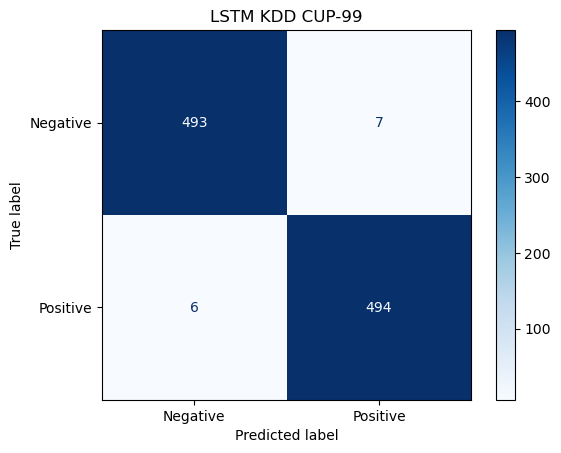

In [4]:
server.evaluate_model(DataLoader(test_dataset, batch_size=32, shuffle=False))